<a href="https://colab.research.google.com/github/adheeb4/7PAM2002_0509_2023_Final_Project/blob/main/Final_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
from google.colab import files
from google.colab import drive
import os
import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import LabelEncoder

import pandas as pd
from sklearn.model_selection import train_test_split

In [ ]:
#!pip install h2o

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 265.3/265.3 MB 8.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for h2o: filename=h2o-3.46.0.4-py2.py3-none-any.whl size=265375569 sha256=e44bf081ee4b66c58d5bcf932026a74eb73a9696e8e963758e9d78c17343301d
  Stored in directory: /root/.cache/pip/wheels/4d/a6/47/8bfeb1026fd65cb8630beb74d8e3bec844f572cf4f336fdd56
Successfully built h2o


In [2]:
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
file_path = '/content/drive/MyDrive/Data/'

fundamentals_df = pd.read_csv(file_path + 'fundamentals.csv')
prices_df = pd.read_csv(file_path + 'prices.csv')
prices_split_adjusted_df = pd.read_csv(file_path + 'prices-split-adjusted.csv')
securities_df = pd.read_csv(file_path + 'securities.csv')


prices_df['date'] = pd.to_datetime(prices_df['date'], format='mixed')

# Format the 'date' column to 'YYYY-MM-DD'
prices_df['date'] = prices_df['date'].dt.strftime('%Y-%m-%d')



print("Fundamentals Data")
print(fundamentals_df.head())

print("\nPrices Data")
print(prices_df.head())

print("\nPrices Split Adjusted Data")
print(prices_split_adjusted_df.head())

print("\nSecurities Data")
print(securities_df.head())

Fundamentals Data
   Unnamed: 0 Ticker Symbol Period Ending  Accounts Payable  \
0           0           AAL    2012-12-31      3.068000e+09   
1           1           AAL    2013-12-31      4.975000e+09   
2           2           AAL    2014-12-31      4.668000e+09   
3           3           AAL    2015-12-31      5.102000e+09   
4           4           AAP    2012-12-29      2.409453e+09   

   Accounts Receivable  Add'l income/expense items  After Tax ROE  \
0         -222000000.0               -1.961000e+09           23.0   
1          -93000000.0               -2.723000e+09           67.0   
2         -160000000.0               -1.500000e+08          143.0   
3          352000000.0               -7.080000e+08          135.0   
4          -89482000.0                6.000000e+05           32.0   

   Capital Expenditures  Capital Surplus  Cash Ratio  ...  \
0         -1.888000e+09     4.695000e+09        53.0  ...   
1         -3.114000e+09     1.059200e+10        75.0  ...   
2    

In [4]:
print(prices_df)

              date symbol        open       close         low        high  \
0       2016-01-05   WLTW  123.430000  125.839996  122.309998  126.250000   
1       2016-01-06   WLTW  125.239998  119.980003  119.940002  125.540001   
2       2016-01-07   WLTW  116.379997  114.949997  114.930000  119.739998   
3       2016-01-08   WLTW  115.480003  116.620003  113.500000  117.440002   
4       2016-01-11   WLTW  117.010002  114.970001  114.089996  117.330002   
...            ...    ...         ...         ...         ...         ...   
851259  2016-12-30    ZBH  103.309998  103.199997  102.849998  103.930000   
851260  2016-12-30   ZION   43.070000   43.040001   42.689999   43.310001   
851261  2016-12-30    ZTS   53.639999   53.529999   53.270000   53.740002   
851262  2016-12-30    AIV   44.730000   45.450001   44.410000   45.590000   
851263  2016-12-30    FTV   54.200001   53.630001   53.389999   54.480000   

           volume  
0       2163600.0  
1       2386400.0  
2       2489500

In [6]:
# Distribution graphs (histogram/bar graph) of column data
def plotPerColumnDistribution(df, nGraphShown, nGraphPerRow):
    nunique = df.nunique()
    df = df[[col for col in df if nunique[col] > 1 and nunique[col] < 50]] # For displaying purposes, pick columns that have between 1 and 50 unique values
    nRow, nCol = df.shape
    columnNames = list(df)
    nGraphRow = (nCol + nGraphPerRow - 1) / nGraphPerRow
    plt.figure(num = None, figsize = (6 * nGraphPerRow, 8 * nGraphRow), dpi = 80, facecolor = 'w', edgecolor = 'k')
    for i in range(min(nCol, nGraphShown)):
        plt.subplot(nGraphRow, nGraphPerRow, i + 1)
        columnDf = df.iloc[:, i]
        if (not np.issubdtype(type(columnDf.iloc[0]), np.number)):
            valueCounts = columnDf.value_counts()
            valueCounts.plot.bar()
        else:
            columnDf.hist()
        plt.ylabel('counts')
        plt.xticks(rotation = 90)
        plt.title(f'{columnNames[i]} (column {i})')
    plt.tight_layout(pad = 1.0, w_pad = 1.0, h_pad = 1.0)
    plt.show()

In [ ]:
def plotCorrelationMatrix(df, graphWidth, filename='DataFrame'):
    # Ensure the DataFrame only contains numeric columns
    df = df.select_dtypes(include=[float, int])
    df = df.dropna(axis='columns')  # drop columns with NaN
    df = df[[col for col in df if df[col].nunique() > 1]]  # keep columns with more than 1 unique value

    if df.shape[1] < 2:
        print(f'No correlation plots shown: The number of non-NaN or constant columns ({df.shape[1]}) is less than 2')
        return

    corr = df.corr()
    plt.figure(num=None, figsize=(graphWidth, graphWidth), dpi=80, facecolor='w', edgecolor='k')
    corrMat = plt.matshow(corr, fignum=1)

    plt.xticks(range(len(corr.columns)), corr.columns, rotation=90)
    plt.yticks(range(len(corr.columns)), corr.columns)
    plt.gca().xaxis.tick_bottom()
    plt.colorbar(corrMat)

    plt.title(f'Correlation Matrix for {filename}', fontsize=15)
    plt.show()

In [ ]:
def plotScatterMatrix(df, plotSize, textSize, maxColumns=10):
    # Ensure the DataFrame only contains numeric columns
    df = df.select_dtypes(include=[np.number])

    # Remove rows and columns that would lead to df being singular
    df = df.dropna(axis='columns')
    df = df[[col for col in df if df[col].nunique() > 1]]  # keep columns where there are more than 1 unique value

    if df.shape[1] < 2:
        print(f'No scatter matrix plots shown: The number of non-NaN or constant columns ({df.shape[1]}) is less than 2')
        return

    # Limit the number of columns
    if df.shape[1] > maxColumns:
        print(f'Too many columns to display ({df.shape[1]}), displaying the first {maxColumns} columns.')
        df = df.iloc[:, :maxColumns]

    columnNames = list(df)
    df = df[columnNames].dropna()

    # Create scatter matrix
    ax = pd.plotting.scatter_matrix(df, alpha=0.75, figsize=(plotSize, plotSize), diagonal='kde')

    # Add title
    corr = df.corr().values
    for i, j in zip(*np.triu_indices_from(corr, 1)):
        ax[i, j].annotate(f'{corr[i, j]:.2f}', (0.8, 0.2), textcoords='axes fraction', ha='center', va='center', fontsize=textSize)

    plt.suptitle('Scatter Matrix')
    plt.show()

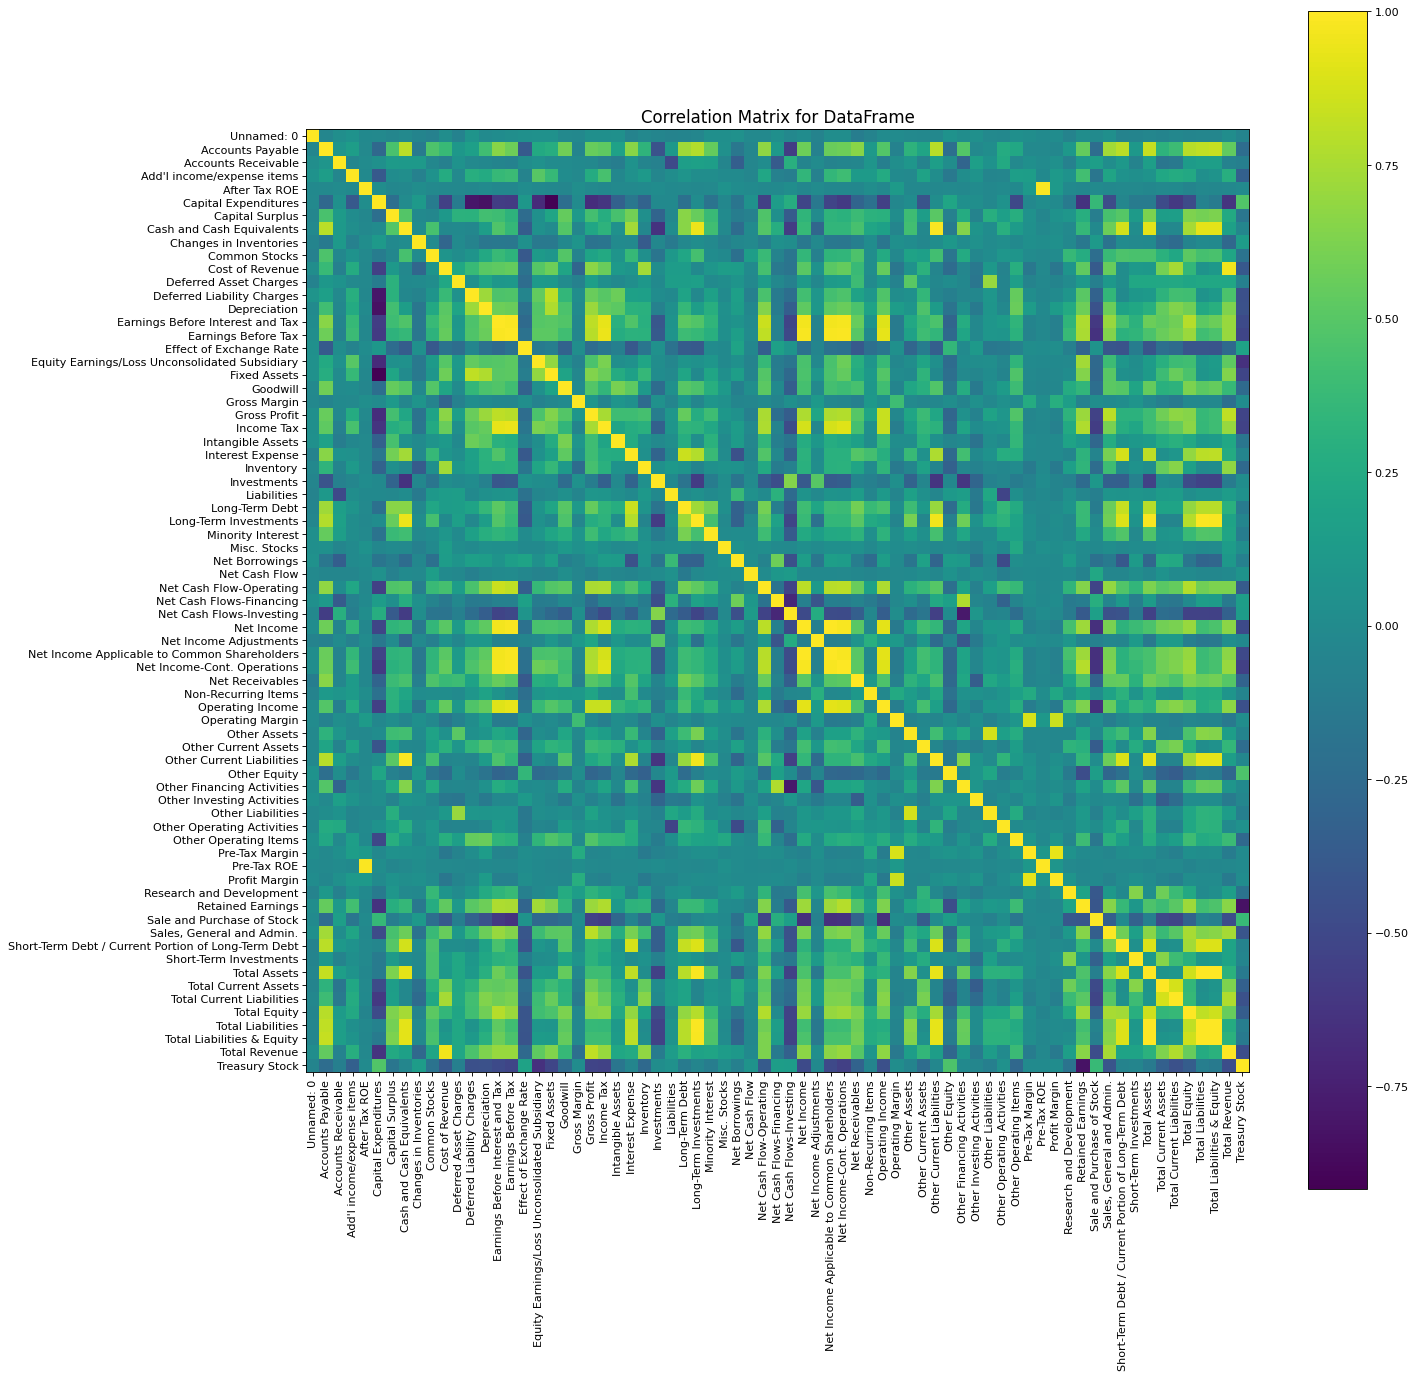

In [ ]:
plotCorrelationMatrix(fundamentals_df, 19)

Too many columns to display (71), displaying the first 10 columns.


<ipython-input-7-d8ec7bf7104e>:27: UserWarning: You have used the `textcoords` kwarg, but not the `xytext` kwarg.  This can lead to surprising results.
  ax[i, j].annotate(f'{corr[i, j]:.2f}', (0.8, 0.2), textcoords='axes fraction', ha='center', va='center', fontsize=textSize)


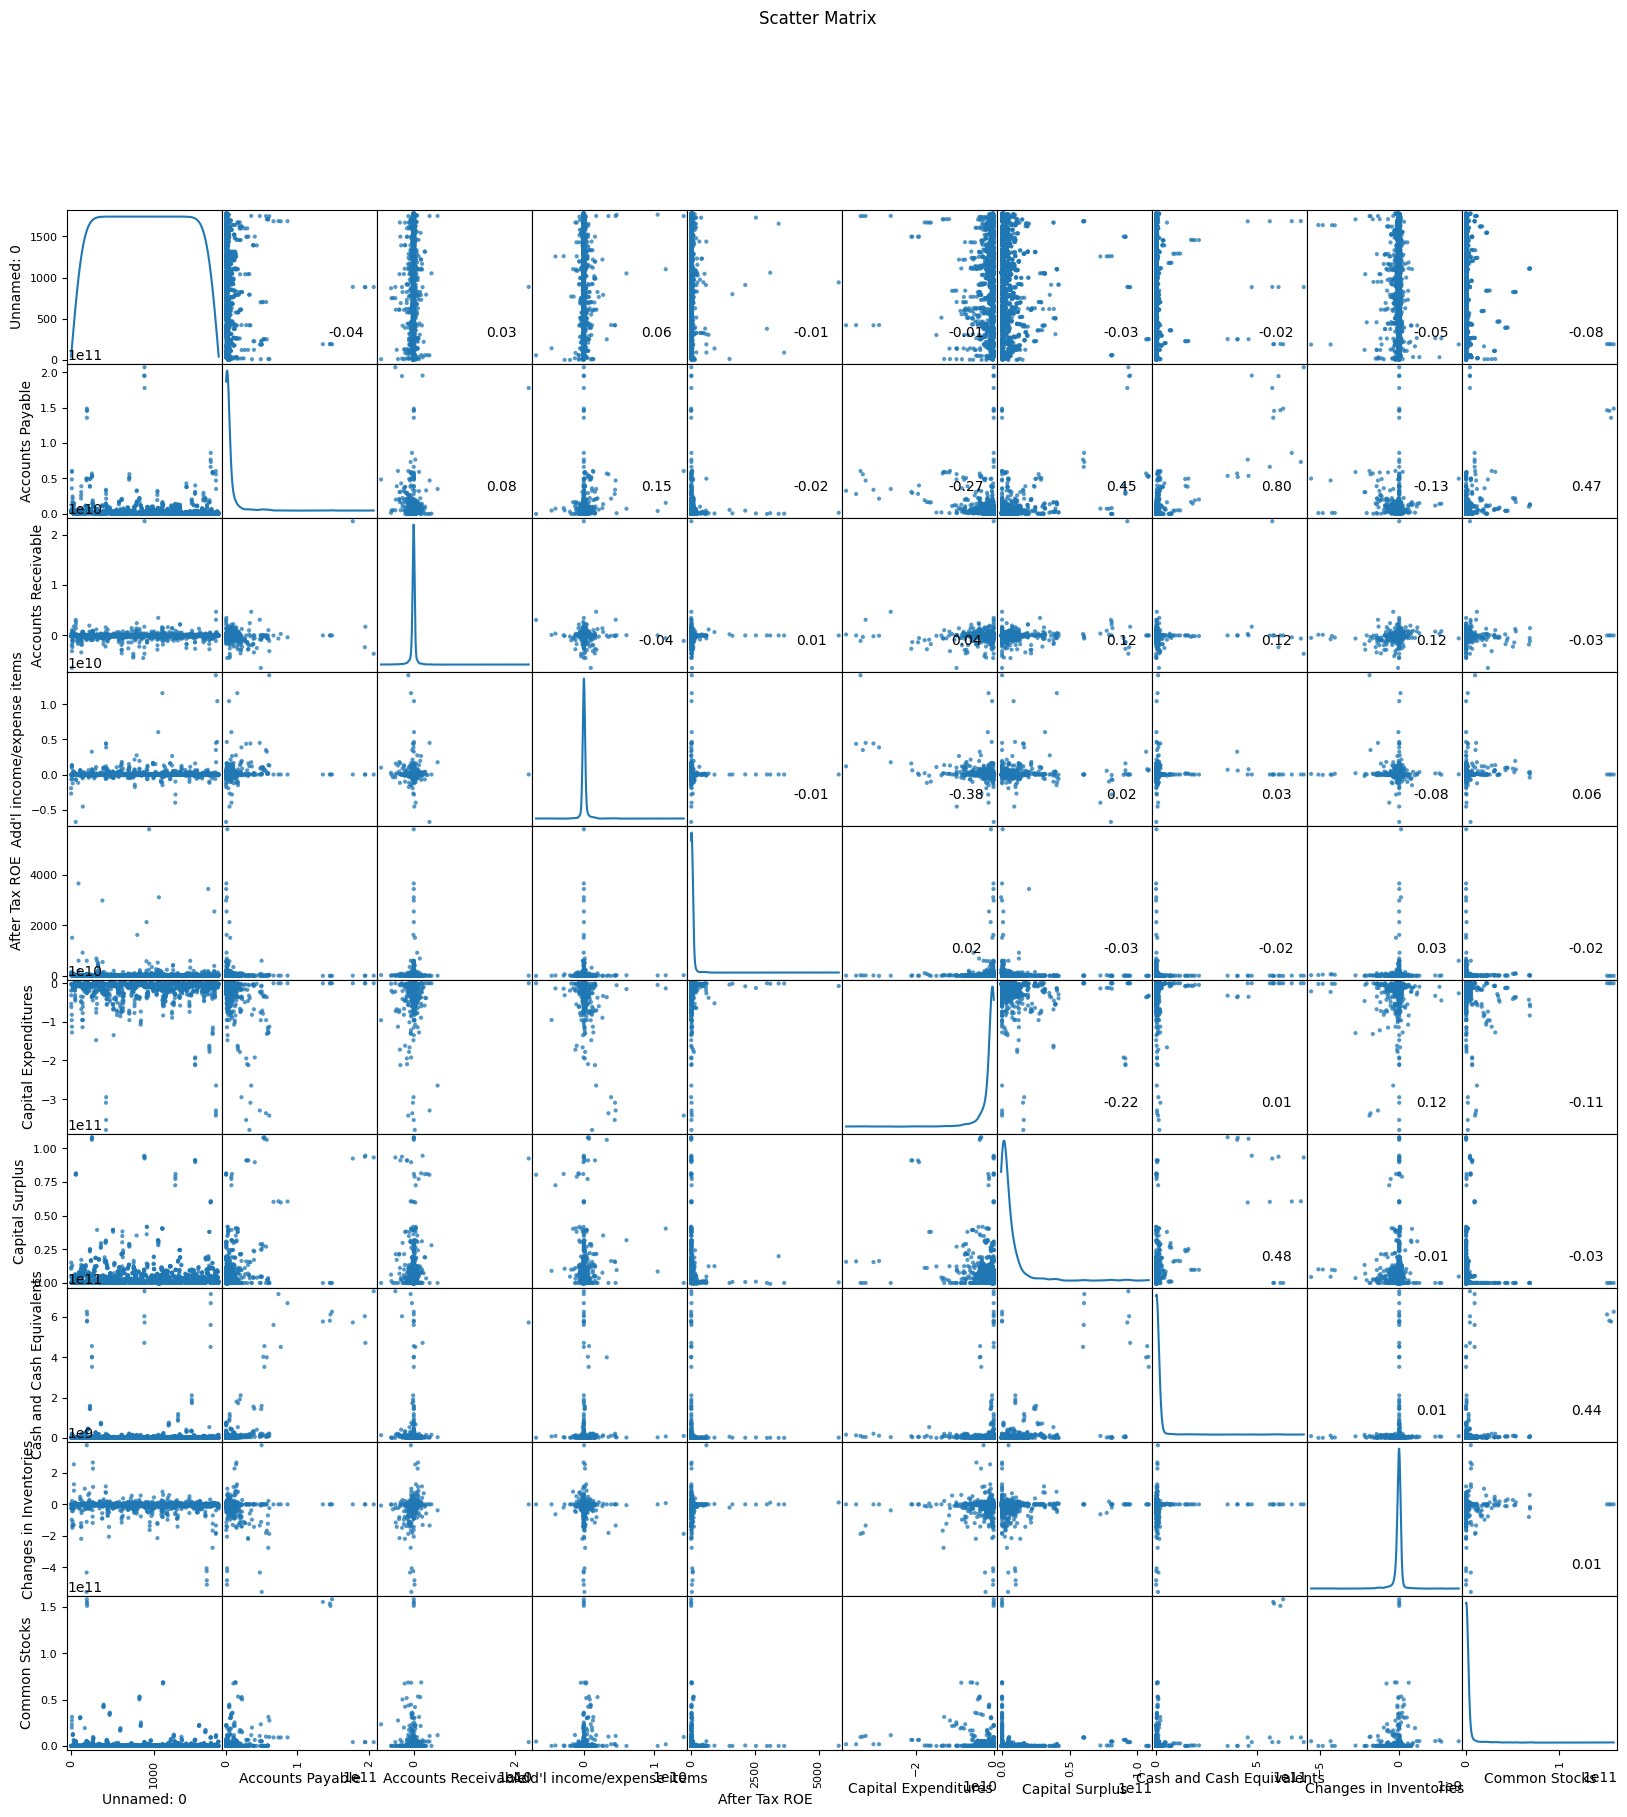

In [ ]:
plotScatterMatrix(fundamentals_df, 20, 10)

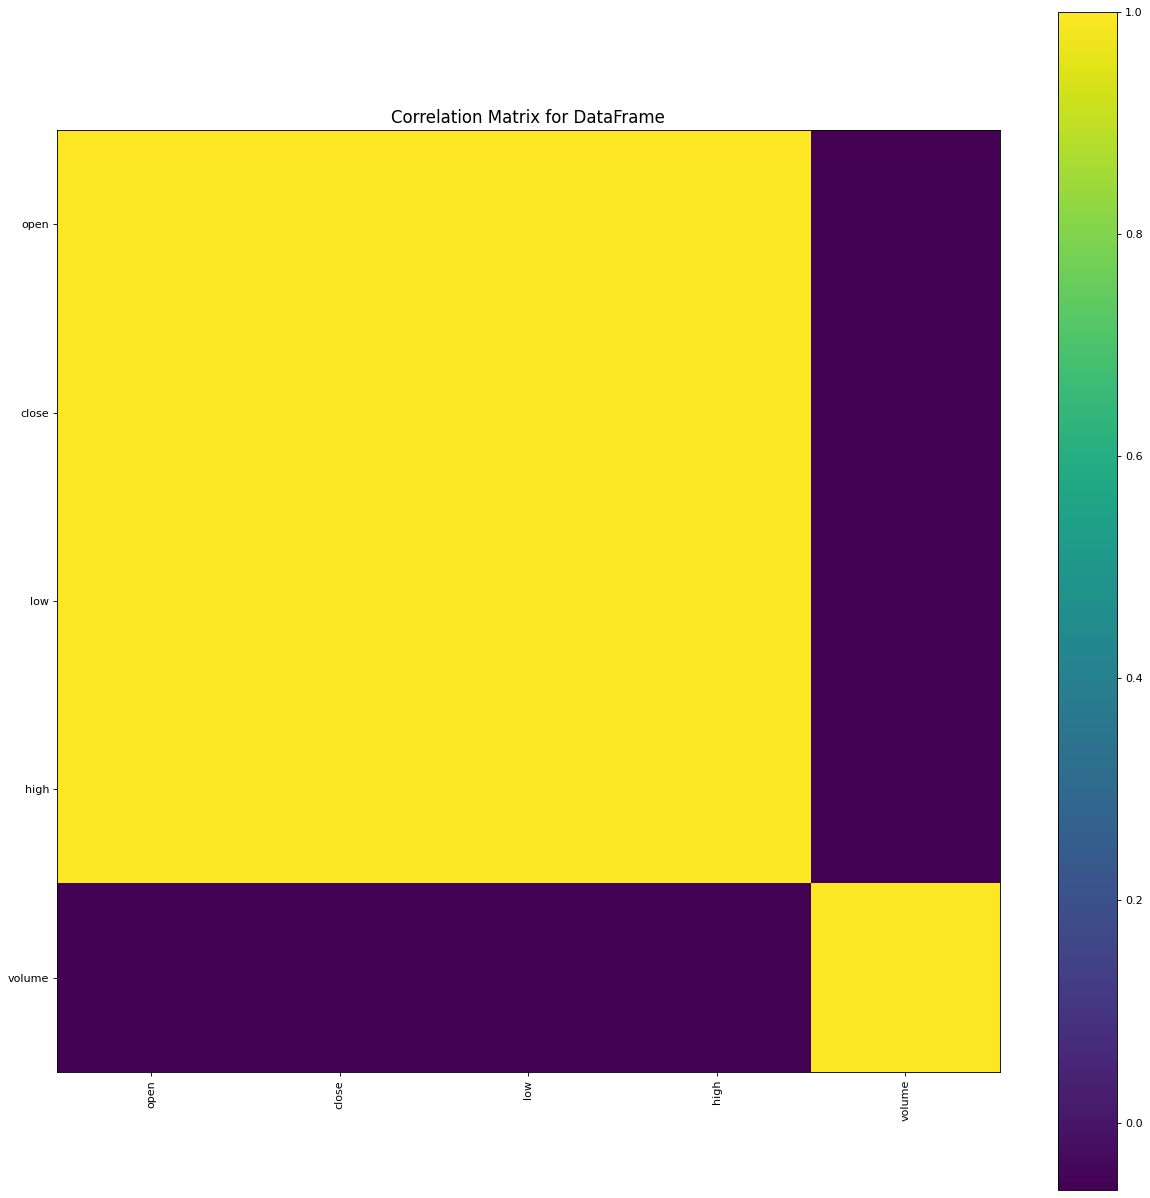

In [ ]:
plotCorrelationMatrix(prices_df, 19)

In [ ]:
#plotScatterMatrix(prices_df, 19, 10)

In [4]:
def extract_date_features(df, date_col='date', date_format='%Y-%m-%d'):
    df[date_col] = pd.to_datetime(df[date_col], format=date_format, errors='coerce')
    df['year'] = df[date_col].dt.year
    df['month'] = df[date_col].dt.month
    df['day'] = df[date_col].dt.day
    df['day_of_week'] = df[date_col].dt.dayofweek
    return df


In [5]:
df = extract_date_features(prices_df)

In [6]:
df['prev_close'] = df.groupby('symbol')['close'].shift(1)
df['close_rolling_mean_7'] = df.groupby('symbol')['close'].transform(lambda x: x.rolling(window=7).mean())
df['close_rolling_std_7'] = df.groupby('symbol')['close'].transform(lambda x: x.rolling(window=7).std())

In [7]:
prices_df['daily_return'] = prices_df.groupby('symbol')['close'].pct_change()


In [8]:
fundamentals_df['debt_to_equity'] = fundamentals_df['Total Liabilities'] / fundamentals_df['Total Equity']
fundamentals_df['current_ratio'] = fundamentals_df['Total Current Assets'] / fundamentals_df['Total Current Liabilities']
fundamentals_df['return_on_assets'] = fundamentals_df['Net Income'] / fundamentals_df['Total Assets']

In [9]:
combined_df = pd.merge(prices_df, fundamentals_df, left_on=['symbol', 'year'], right_on=['Ticker Symbol', 'For Year'], how='left')

In [11]:
print(combined_df.head())

        date symbol        open       close         low        high  \
0 2016-01-05   WLTW  123.430000  125.839996  122.309998  126.250000   
1 2016-01-06   WLTW  125.239998  119.980003  119.940002  125.540001   
2 2016-01-07   WLTW  116.379997  114.949997  114.930000  119.739998   
3 2016-01-08   WLTW  115.480003  116.620003  113.500000  117.440002   
4 2016-01-11   WLTW  117.010002  114.970001  114.089996  117.330002   

      volume  year  month  day  ...  Total Liabilities  \
0  2163600.0  2016      1    5  ...                NaN   
1  2386400.0  2016      1    6  ...                NaN   
2  2489500.0  2016      1    7  ...                NaN   
3  2006300.0  2016      1    8  ...                NaN   
4  1408600.0  2016      1   11  ...                NaN   

   Total Liabilities & Equity  Total Revenue  Treasury Stock  For Year  \
0                         NaN            NaN             NaN       NaN   
1                         NaN            NaN             NaN       NaN   
2 

In [10]:
combined_df = combined_df.iloc[:, :15]

In [11]:
securities_df = securities_df.rename(columns={'Ticker symbol': 'symbol'})
combined_df = pd.merge(combined_df, securities_df[['symbol', 'GICS Sector', 'GICS Sub Industry']], on='symbol', how='left')

In [12]:
combined_df = combined_df.fillna(method='bfill')

<ipython-input-12-4a1070dfbd1e>:1: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  combined_df = combined_df.fillna(method='bfill')


In [13]:
combined_df = pd.get_dummies(combined_df, columns=['GICS Sector', 'GICS Sub Industry'])

In [14]:
boolean_cols = combined_df.select_dtypes(include=['bool']).columns

combined_df[boolean_cols] = combined_df[boolean_cols].astype(int)

In [17]:
print(combined_df)

             date symbol        open       close         low        high  \
0      2016-01-05   WLTW  123.430000  125.839996  122.309998  126.250000   
1      2016-01-06   WLTW  125.239998  119.980003  119.940002  125.540001   
2      2016-01-07   WLTW  116.379997  114.949997  114.930000  119.739998   
3      2016-01-08   WLTW  115.480003  116.620003  113.500000  117.440002   
4      2016-01-11   WLTW  117.010002  114.970001  114.089996  117.330002   
...           ...    ...         ...         ...         ...         ...   
852769 2016-12-30    ZBH  103.309998  103.199997  102.849998  103.930000   
852770 2016-12-30   ZION   43.070000   43.040001   42.689999   43.310001   
852771 2016-12-30    ZTS   53.639999   53.529999   53.270000   53.740002   
852772 2016-12-30    AIV   44.730000   45.450001   44.410000   45.590000   
852773 2016-12-30    FTV   54.200001   53.630001   53.389999   54.480000   

           volume  year  month  day  ...  GICS Sub Industry_Systems Software  \
0      

In [ ]:
#plotCorrelationMatrix(combined_df, 30)

In [18]:
X = combined_df.drop(['close'], axis=1)
y = combined_df['close']

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [ ]:
import h2o
h2o.init()

Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
  Java Version: openjdk version "11.0.24" 2024-07-16; OpenJDK Runtime Environment (build 11.0.24+8-post-Ubuntu-1ubuntu322.04); OpenJDK 64-Bit Server VM (build 11.0.24+8-post-Ubuntu-1ubuntu322.04, mixed mode, sharing)
  Starting server from /usr/local/lib/python3.10/dist-packages/h2o/backend/bin/h2o.jar
  Ice root: /tmp/tmpmosg84hz
  JVM stdout: /tmp/tmpmosg84hz/h2o_unknownUser_started_from_python.out
  JVM stderr: /tmp/tmpmosg84hz/h2o_unknownUser_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,02 secs
H2O_cluster_timezone:,Etc/UTC
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.46.0.4
H2O_cluster_version_age:,1 month and 6 days
H2O_cluster_name:,H2O_from_python_unknownUser_ift9nw
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,20.87 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,12
H2O_cluster_status:,"locked, healthy"


In [ ]:
train_h2o = h2o.H2OFrame(pd.concat([X_train, y_train], axis=1))
test_h2o = h2o.H2OFrame(pd.concat([X_test, y_test], axis=1))

Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%


In [ ]:
target_column = 'close'
time_column = 'date'

In [ ]:
from h2o.automl import H2OAutoML
aml = H2OAutoML(max_runtime_secs=300,  # Adjust as needed
                   seed=1)
aml.train(x=list(X_train.columns),
          y=target_column,
          training_frame=train_h2o,
          leaderboard_frame=test_h2o,)

AutoML progress: |███████████████████████████████████████████████████████████████| (done) 100%


key,value
Stacking strategy,blending
Number of base models (used / total),8/8
# GBM base models (used / total),4/4
# XGBoost base models (used / total),2/2
# DRF base models (used / total),1/1
# GLM base models (used / total),1/1
Metalearner algorithm,GLM
Metalearner fold assignment scheme,AUTO
Metalearner nfolds,0
Metalearner fold_column,None


In [ ]:
lb = aml.leaderboard
print(lb)

model_id                                                      rmse         mse       mae       rmsle    mean_residual_deviance
StackedEnsemble_AllModels_1_AutoML_1_20240816_135300      0.650615    0.423299  0.268821  0.00684168                  0.423299
StackedEnsemble_BestOfFamily_2_AutoML_1_20240816_135300   0.695043    0.483084  0.246501  0.00596384                  0.483084
GBM_1_AutoML_1_20240816_135300                            0.733181    0.537554  0.203984  0.00443056                  0.537554
StackedEnsemble_BestOfFamily_1_AutoML_1_20240816_135300   0.748513    0.560271  0.248466  0.00627376                  0.560271
DRF_1_AutoML_1_20240816_135300                            1.16678     1.36138   0.349437  0.00827374                  1.36138
GLM_1_AutoML_1_20240816_135300                            1.2637      1.59693   0.469137  0.0149503                   1.59693
XGBoost_2_AutoML_1_20240816_135300                        2.17535     4.73214   0.500446  0.0104584              

In [ ]:
best_model = aml.leader

In [ ]:
predictions = best_model.predict(test_h2o)

stackedensemble prediction progress: |███████████████████████████████████████████| (done) 100%


In [ ]:
predictions_df = predictions.as_data_frame()

/usr/local/lib/python3.10/dist-packages/h2o/frame.py:1981: H2ODependencyWarning: Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using multi-thread, install polars and pyarrow and use it as pandas_df = h2o_df.as_data_frame(use_multi_thread=True)

  warnings.warn("Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using"


In [ ]:
try:
    lb_df = aml.leaderboard.as_data_frame(use_multi_thread=True)
except ImportError:
    lb_df = aml.leaderboard.as_data_frame()

Export File progress: |██████████████████████████████████████████████████████████| (done) 100%


In [ ]:
print(lb_df.head())
print(lb_df.columns)

                                            model_id      rmse       mse  \
0  StackedEnsemble_AllModels_1_AutoML_1_20240816_...  0.650615  0.423299   
1  StackedEnsemble_BestOfFamily_2_AutoML_1_202408...  0.695043  0.483084   
2                     GBM_1_AutoML_1_20240816_135300  0.733181  0.537554   
3  StackedEnsemble_BestOfFamily_1_AutoML_1_202408...  0.748513  0.560271   
4                     DRF_1_AutoML_1_20240816_135300  1.166782  1.361380   

        mae     rmsle  mean_residual_deviance  
0  0.268821  0.006842                0.423299  
1  0.246501  0.005964                0.483084  
2  0.203984  0.004431                0.537554  
3  0.248466  0.006274                0.560271  
4  0.349437  0.008274                1.361380  
Index(['model_id', 'rmse', 'mse', 'mae', 'rmsle', 'mean_residual_deviance'], dtype='object')


In [ ]:
print(lb_df.columns)


Index(['model_id', 'rmse', 'mse', 'mae', 'rmsle', 'mean_residual_deviance'], dtype='object')


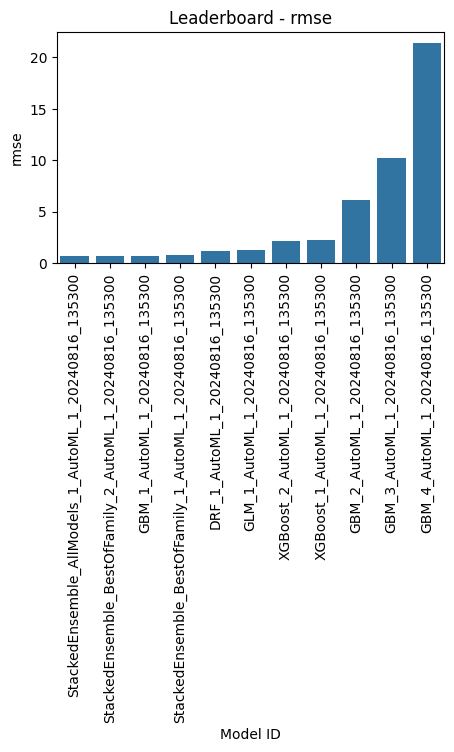

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set the metric column to one of the existing columns
metric_column = 'rmse'  # You can change this to 'mse', 'mae', 'rmsle', etc.

# Plot the leaderboard
plt.figure(figsize=(5, 3))
sns.barplot(x='model_id', y=metric_column, data=lb_df)
plt.xticks(rotation=90)
plt.title(f'Leaderboard - {metric_column}')
plt.xlabel('Model ID')
plt.ylabel(metric_column)
plt.show()


In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Convert leaderboard to pandas DataFrame
lb_df = aml.leaderboard.as_data_frame()

# Plot the leaderboard
plt.figure(figsize=(10, 6))
sns.barplot(x='model_id', y='mean_per_class_error', data=lb_df)
plt.xticks(rotation=90)
plt.title('Model Performance on the Leaderboard')
plt.xlabel('Model ID')
plt.ylabel('Mean Per Class Error')
plt.show()


/usr/local/lib/python3.10/dist-packages/h2o/frame.py:1981: H2ODependencyWarning: Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using multi-thread, install polars and pyarrow and use it as pandas_df = h2o_df.as_data_frame(use_multi_thread=True)

  warnings.warn("Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using"


ValueError: Could not interpret value `mean_per_class_error` for `y`. An entry with this name does not appear in `data`.

<Figure size 1000x600 with 0 Axes>

In [ ]:
print(time_series[time_column].head(10))


/usr/local/lib/python3.10/dist-packages/h2o/frame.py:1981: H2ODependencyWarning: Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using multi-thread, install polars and pyarrow and use it as pandas_df = h2o_df.as_data_frame(use_multi_thread=True)

  warnings.warn("Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using"
/usr/local/lib/python3.10/dist-packages/h2o/frame.py:1981: H2ODependencyWarning: Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using multi-thread, install polars and pyarrow and use it as pandas_df = h2o_df.as_data_frame(use_multi_thread=True)

  warnings.warn("Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using"


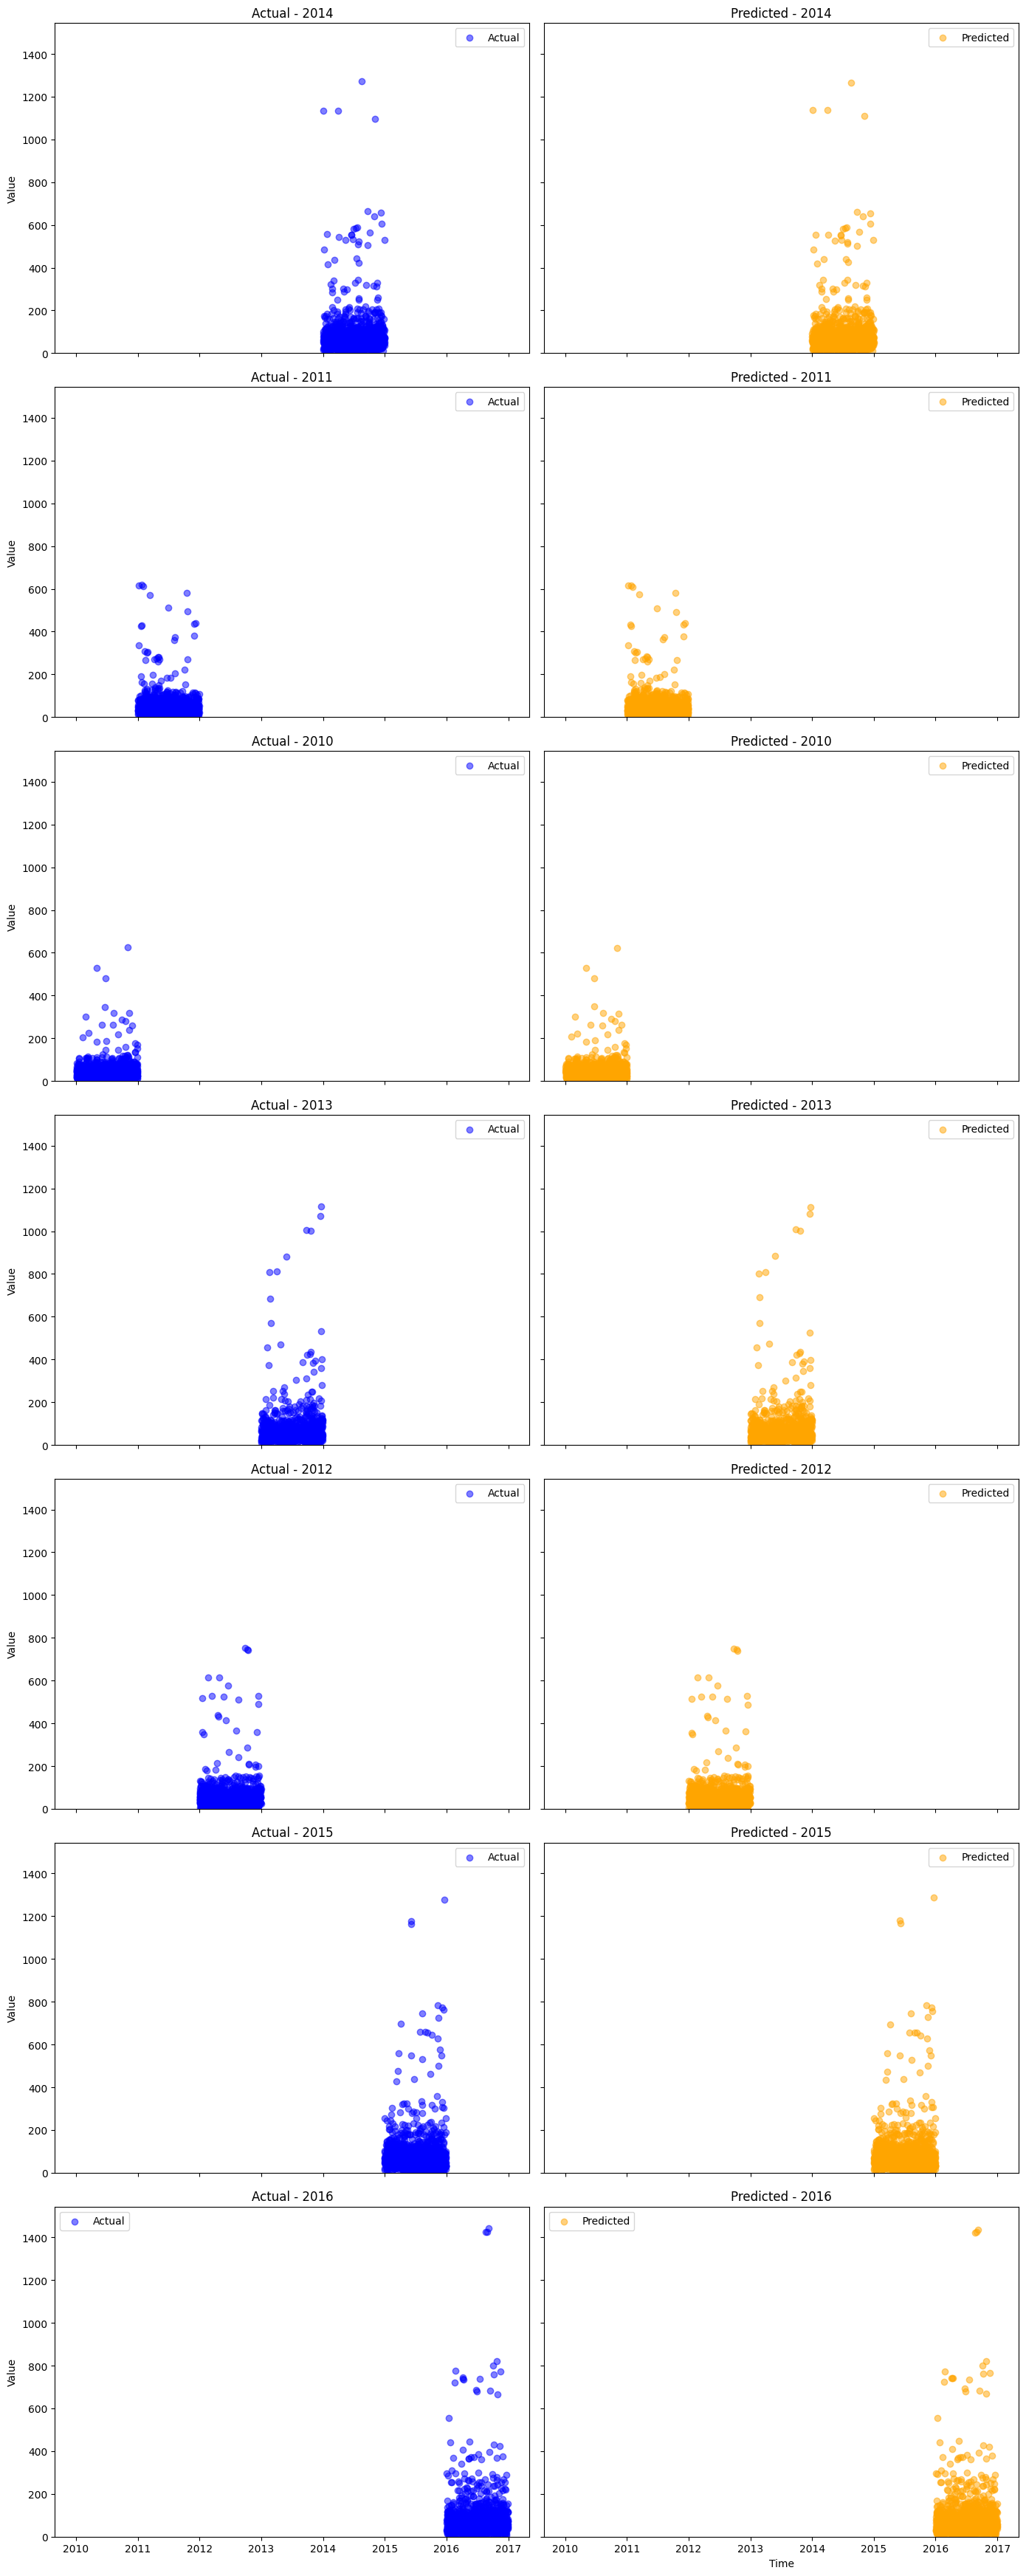

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd

# Convert H2OFrames to Pandas DataFrames
time_series = test_h2o[time_column].as_data_frame()
actual_values = test_h2o[target_column].as_data_frame()

# Convert time column from milliseconds to datetime
time_series[time_column] = pd.to_datetime(time_series[time_column], unit='ms')

# Combine the data into a single DataFrame for easier sorting
df = pd.concat([time_series, actual_values, predictions_df['predict']], axis=1)
df.columns = [time_column, 'Actual', 'Predicted']

# Sort by time column to ensure the plot is in chronological order
df = df.sort_values(by=time_column)

# Extract the year from the datetime column
df['Year'] = df[time_column].dt.year

# Aggressively downsample the data for better visibility
df = df.sample(frac=0.05, random_state=42)

# Get the unique years in the dataset
years = df['Year'].unique()

# Create subplots - one for each year, separating actual and predicted plots
fig, axes = plt.subplots(len(years), 2, figsize=(14, 5 * len(years)), sharex=True, sharey=True)

# Plot each year separately
for i, year in enumerate(years):
    # Filter data for the current year
    df_year = df[df['Year'] == year]

    # Scatter plot for actual values
    axes[i, 0].scatter(df_year[time_column], df_year['Actual'], label='Actual', color='blue', alpha=0.5)
    axes[i, 0].set_title(f'Actual - {year}')
    axes[i, 0].set_ylabel('Value')

    # Scatter plot for predicted values
    axes[i, 1].scatter(df_year[time_column], df_year['Predicted'], label='Predicted', color='orange', alpha=0.5)
    axes[i, 1].set_title(f'Predicted - {year}')

    # Add legend
    axes[i, 0].legend()
    axes[i, 1].legend()

    # Optionally set y-axis limits (modify as needed)
    axes[i, 0].set_ylim([0, df['Actual'].max() + 100])

# Set common labels
plt.xlabel('Time')
plt.tight_layout()

# Show plot
plt.show()


In [ ]:
import matplotlib.pyplot as plt
import pandas as pd

# Convert H2OFrames to Pandas DataFrames
time_series = test_h2o[time_column].as_data_frame()
actual_values = test_h2o[target_column].as_data_frame()

# Convert time column from milliseconds to datetime
time_series[time_column] = pd.to_datetime(time_series[time_column], unit='ms')

# Combine the data into a single DataFrame for easier sorting
df = pd.concat([time_series, actual_values, predictions_df['predict']], axis=1)
df.columns = [time_column, 'Actual', 'Predicted']

# Sort by time column to ensure the plot is in chronological order
df = df.sort_values(by=time_column)

# Increase the plot size for better readability
plt.figure(figsize=(14, 8))

# Plot actual values
plt.plot(df[time_column], df['Actual'], label='Actual')

# Plot predicted values
plt.plot(df[time_column], df['Predicted'], label='Predicted')

# Add legend to distinguish between actual and predicted lines
plt.legend()

# Add titles and labels for clarity
plt.title('Actual vs Predicted over Time')
plt.xlabel('Time')
plt.ylabel('Value')

# Show plot
plt.show()


In [ ]:
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout

# Initialize the model
model = Sequential()

# Add LSTM layers
model.add(LSTM(units=50, return_sequences=True, input_shape=(X.shape[1], 1)))
model.add(Dropout(0.2))

model.add(LSTM(units=50, return_sequences=False))
model.add(Dropout(0.2))

# Add Dense layers
model.add(Dense(units=25))
model.add(Dense(units=1))  # Output layer with one unit for the predicted price

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

# View the model summary
model.summary()


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                          │ (None, 2, 50)               │          10,400 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 2, 50)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_1 (LSTM)                        │ (None, 50)                  │          20,200 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 50)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 25)                  │           1,275 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │              26 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 31,901 (124.61 KB)

 Trainable params: 31,901 (124.61 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
import pandas as pd
import numpy as np

# Assuming df is your original DataFrame
# Drop the 'date' column before creating sequences
time_column = 'date'
df = combined_df.drop(columns=[time_column])

# One-hot encode categorical variables if necessary
df = pd.get_dummies(df, columns=['symbol'])

# Normalize the DataFrame
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_df = scaler.fit_transform(df)

# Convert back to DataFrame for sequence creation
scaled_df = pd.DataFrame(scaled_df, columns=df.columns)

# Create sequences for LSTM
sequence_length = 5
X, y = [], []

for i in range(sequence_length, len(scaled_df)):
    X.append(scaled_df.iloc[i-sequence_length:i].values)
    y.append(scaled_df.iloc[i].values)

X = np.array(X)
y = np.array(y)

# Now split into training and testing
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)



In [ ]:
# Train the model on the training data
model.fit(X_train, y_train, epochs=50, batch_size=32, validation_data=(X_test, y_test))


In [18]:
specific_symbol = 'AAPL'
symbol_df = combined_df[combined_df['symbol'] == specific_symbol].drop(columns=['symbol'])

In [19]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler


# Drop the 'date' column since it’s not needed for the LSTM model
df = symbol_df.drop(columns=['date'])


# Normalize the DataFrame using MinMaxScaler
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_df = scaler.fit_transform(df)

# Convert back to DataFrame for easier handling
scaled_df = pd.DataFrame(scaled_df, columns=df.columns)


In [32]:
subset_df = scaled_df.sample(frac=1, random_state=42)  # Use 10% of the data for training


In [21]:
close_index = scaled_df.columns.get_loc("close")
sequence_length = 100  # Use the past 60 days to predict the next day
X, y = [], []

for i in range(sequence_length, len(scaled_df)):
    X.append(scaled_df.iloc[i-sequence_length:i].values)
    y.append(scaled_df.iloc[i, close_index])

X = np.array(X)
y = np.array(y)


In [22]:
from sklearn.model_selection import train_test_split

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [25]:
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize the LSTM model
model = Sequential()

# Add LSTM layers with dropout to prevent overfitting
model.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dropout(0.2))

model.add(LSTM(units=50, return_sequences=False))
model.add(Dropout(0.2))

# Add a Dense layer to output the close price prediction
model.add(Dense(units=1))  # Only one output for the close price

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

# Train the model
model.fit(X_train, y_train, epochs=100, batch_size=8, validation_data=(X_test, y_test))

# Evaluate the model
test_loss = model.evaluate(X_test, y_test)
print(f'Test Loss: {test_loss}')

# Extract the 'close' column from the original DataFrame for inverse scaling
close_scaler = MinMaxScaler(feature_range=(0, 1)) # Create a new scaler for just the close column
close_scaler.fit(df['close'].values.reshape(-1, 1)) # Fit it to the original close values


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/100
167/167 ━━━━━━━━━━━━━━━━━━━━ 6s 14ms/step - loss: 0.0231 - val_loss: 0.0049
Epoch 2/100
167/167 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 0.0052 - val_loss: 8.9665e-04
Epoch 3/100
167/167 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 0.0056 - val_loss: 7.2363e-04
Epoch 4/100
167/167 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 0.0041 - val_loss: 5.0294e-04
Epoch 5/100
167/167 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 0.0037 - val_loss: 0.0040
Epoch 6/100
167/167 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 0.0040 - val_loss: 0.0018
Epoch 7/100
167/167 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 0.0053 - val_loss: 8.1969e-04
Epoch 8/100
167/167 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 0.0055 - val_loss: 7.2876e-04
Epoch 9/100
167/167 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 0.0026 - val_loss: 5.8562e-04
Epoch 10/100
167/167 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 0.0035 - val_loss: 4.2627e-04
Epoch 11/100
167/167 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 0.0040 - val_loss: 0.0014
Ep

MinMaxScaler()

In [53]:
!pip install keras-tuner


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.1/129.1 kB 8.9 MB/s eta 0:00:00


In [ ]:
import numpy as np
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam

# Define the hyperparameter grid
param_grid = {
    'units': [50, 100, 150],
    'dropout_rate': [0.2, 0.3],
    'batch_size': [8, 16, 32],
    'epochs': [50, 100],
    'learning_rate': [0.001, 0.01]
}

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# To store the best score and the corresponding hyperparameters
best_score = float('inf')
best_params = {}

# Grid search
for units in param_grid['units']:
    for dropout_rate in param_grid['dropout_rate']:
        for batch_size in param_grid['batch_size']:
            for epochs in param_grid['epochs']:
                for learning_rate in param_grid['learning_rate']:
                    print(f"Training with units={units}, dropout_rate={dropout_rate}, batch_size={batch_size}, epochs={epochs}, learning_rate={learning_rate}")

                    # Build the model
                    model = Sequential()
                    model.add(LSTM(units=units, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
                    model.add(Dropout(dropout_rate))
                    model.add(LSTM(units=units, return_sequences=False))
                    model.add(Dropout(dropout_rate))
                    model.add(Dense(units=1))

                    # Compile the model
                    optimizer = Adam(learning_rate=learning_rate)
                    model.compile(optimizer=optimizer, loss='mean_squared_error')

                    # Train the model
                    history = model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, validation_data=(X_test, y_test), verbose=0)

                    # Evaluate the model
                    score = model.evaluate(X_test, y_test, verbose=0)
                    print(f"Validation loss: {score}")

                    # If this score is better, update best_score and best_params
                    if score < best_score:
                        best_score = score
                        best_params = {
                            'units': units,
                            'dropout_rate': dropout_rate,
                            'batch_size': batch_size,
                            'epochs': epochs,
                            'learning_rate': learning_rate
                        }

print(f"Best Validation Loss: {best_score}")
print(f"Best Hyperparameters: {best_params}")


Training with units=50, dropout_rate=0.2, batch_size=8, epochs=50, learning_rate=0.001


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Validation loss: 0.00030413392232730985
Training with units=50, dropout_rate=0.2, batch_size=8, epochs=50, learning_rate=0.01
Validation loss: 0.0009421493159607053
Training with units=50, dropout_rate=0.2, batch_size=8, epochs=100, learning_rate=0.001
Validation loss: 0.0002477860252838582
Training with units=50, dropout_rate=0.2, batch_size=8, epochs=100, learning_rate=0.01
Validation loss: 0.0007533521275036037
Training with units=50, dropout_rate=0.2, batch_size=16, epochs=50, learning_rate=0.001
Validation loss: 0.0003127949603367597
Training with units=50, dropout_rate=0.2, batch_size=16, epochs=50, learning_rate=0.01
Validation loss: 0.000492856081109494
Training with units=50, dropout_rate=0.2, batch_size=16, epochs=100, learning_rate=0.001
Validation loss: 0.0009707707213237882
Training with units=50, dropout_rate=0.2, batch_size=16, epochs=100, learning_rate=0.01
Validation loss: 0.0009682340314611793
Training with units=50, dropout_rate=0.2, batch_size=32, epochs=50, learnin

11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


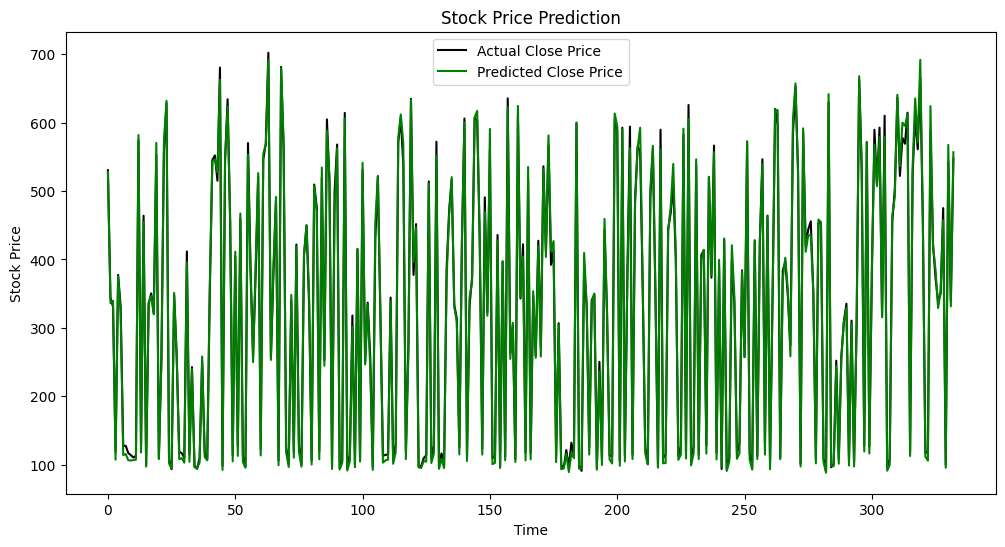

In [26]:
predicted = model.predict(X_test)
# Inverse transform the predicted and actual close prices
predicted = close_scaler.inverse_transform(predicted) # Use the new scaler to inverse transform
y_test = close_scaler.inverse_transform(y_test.reshape(-1, 1))

# Compare predictions with actual values
import matplotlib.pyplot as plt

plt.figure(figsize=(12,6))
plt.plot(y_test, color='black', label='Actual Close Price')
plt.plot(predicted, color='green', label='Predicted Close Price')
plt.title('Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('Stock Price')
plt.legend()
plt.show()


In [27]:
from sklearn.metrics import mean_squared_error
import numpy as np

# Calculate the RMSE
rmse = np.sqrt(mean_squared_error(y_test, predicted))
print(f'RMSE: {rmse}')


RMSE: 10.51366193163137


In [ ]:
predicted_close = close_scaler.inverse_transform(predicted.reshape(-1, 1))
y_test_close = close_scaler.inverse_transform(y_test.reshape(-1, 1))

# Compare predictions with actual values
plt.figure(figsize=(12,6))
plt.plot(y_test_close, color='black', label='Actual Close Price')
plt.plot(predicted_close, color='green', label='Predicted Close Price')
plt.title('Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('Stock Price')
plt.legend()
plt.show()

NameError: name 'close_scaler' is not defined

In [19]:
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout

# Initialize the LSTM model
model = Sequential()

# Add LSTM layers with dropout to prevent overfitting
model.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dropout(0.2))

model.add(LSTM(units=50, return_sequences=False))
model.add(Dropout(0.2))

# Add a Dense layer to output predictions
model.add(Dense(units=y_train.shape[1]))  # Output layer with the same number of features as in y

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

# Train the model
model.fit(X_train, y_train, epochs=20, batch_size=32, validation_data=(X_test, y_test))


NameError: name 'X_train' is not defined

533/533 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0051
Test Loss: 0.005120295565575361
533/533 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step


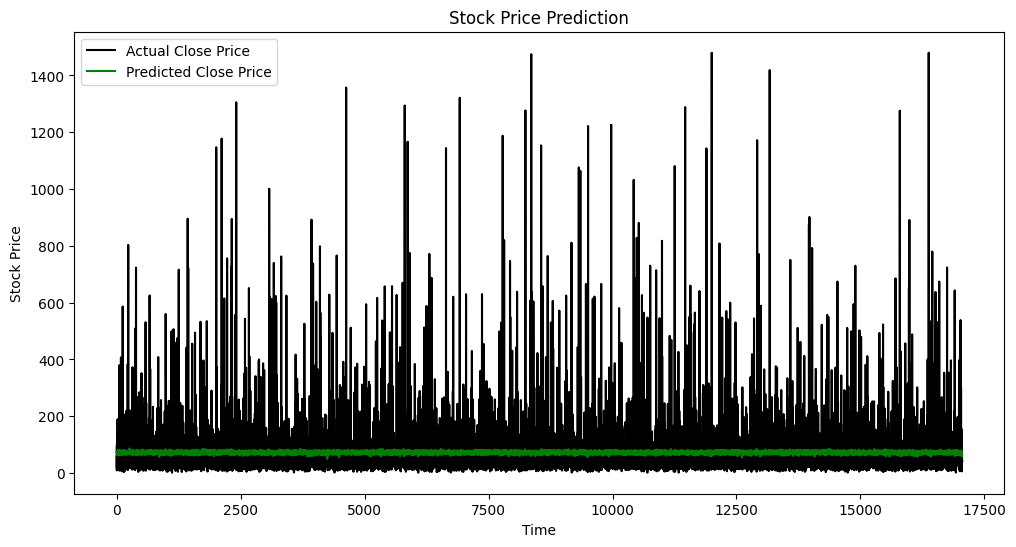

In [ ]:
# Evaluate the model
test_loss = model.evaluate(X_test, y_test)
print(f'Test Loss: {test_loss}')

# Make predictions
predicted = model.predict(X_test)

# Inverse transform the predictions and y_test to the original scale
predicted = scaler.inverse_transform(predicted)
y_test = scaler.inverse_transform(y_test)

# Compare predictions with actual values
import matplotlib.pyplot as plt

plt.figure(figsize=(12,6))
plt.plot(y_test[:, 3], color='black', label='Actual Close Price')  # Assuming 'close' price is at index 3
plt.plot(predicted[:, 3], color='green', label='Predicted Close Price')
plt.title('Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('Stock Price')
plt.legend()
plt.show()
